<a href="https://colab.research.google.com/github/soerenml/colab/blob/master/end_to_end_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End to end ML project

Before you start with the project, make sure you **understand the underlying logic of the problem**. It is important to think in causal relationships first and have a look at the data later. Hence, there should be a clear logical representation of the problem **before** you jump into the data analysis.

Furthermore, make sure you selected the correct **performance measure** for your problem. For example, it makes a significant difference if you use RMSE or RME as the RMSE is more sensitive to outliers.



In [0]:
%%capture
pip uninstall tensorflow

In [0]:
%%capture
pip install tensorflow==2.0 tfx

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
print("Tensorflow version: {}".format(tf.__version__))

%load_ext tensorboard

Tensorflow version: 2.0.0


# Load the data

## Download and extract

In [0]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  """
  Create directory and extract the data (housing.csv)
  """
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

fetch_housing_data()

# Path to the local CSV file
data_path="datasets/housing/housing.csv"

## Check the data

In [0]:
import pandas as pd
df = pd.read_csv(data_path)
df.iloc[1:10,:]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [0]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [0]:
# Note: we only have five observations for ISLAND.
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

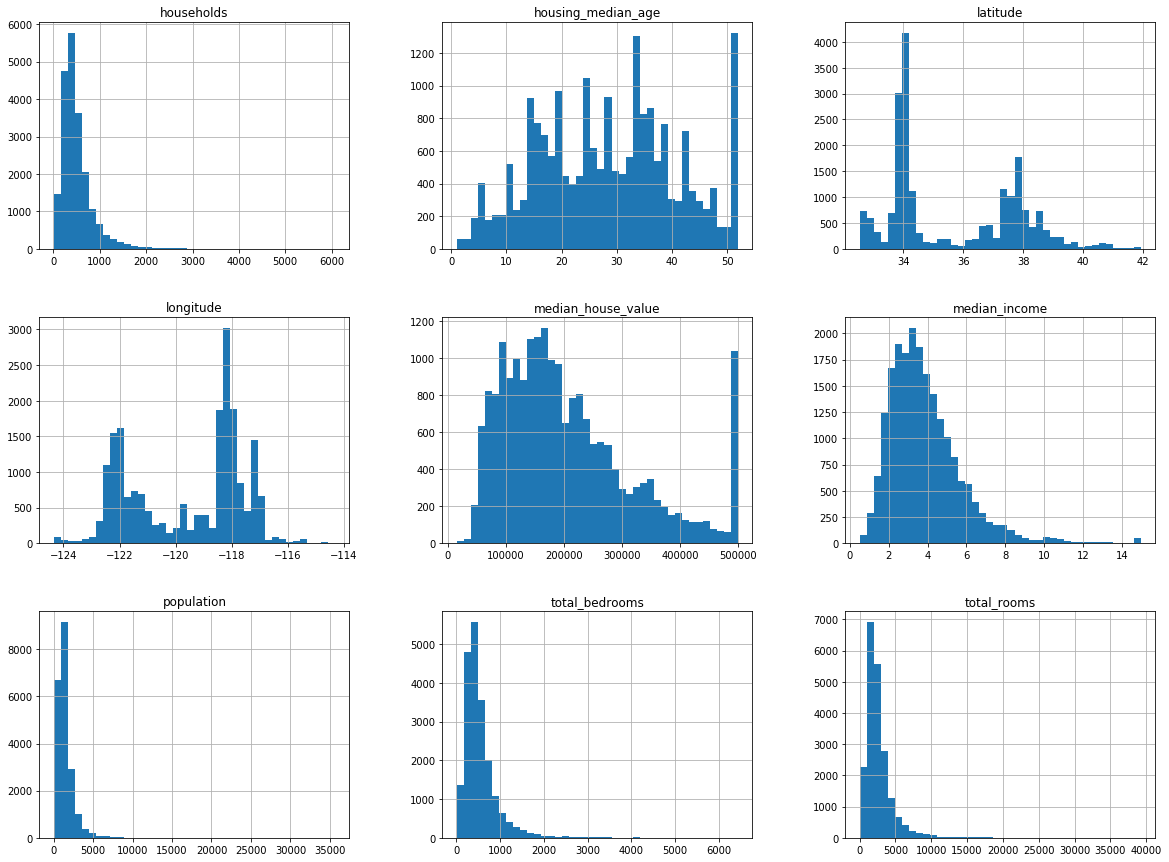

In [0]:
# Note: the housing price has the shape of a gamma distribution with a fat tail
import matplotlib.pyplot as plt
df.hist(bins=40, figsize=(20,15))
plt.show()

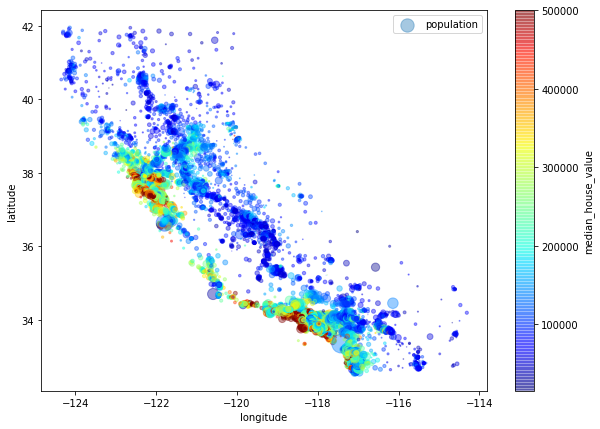

In [0]:
# Plot housing value in the region
df_vis = df.copy()
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=df["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

In [0]:
# Nothing too interesting in here... besides the obvious.
corr_matrix = df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

## Load data into tensorflow

In order to load the data we are using tf.data.

In [0]:
LABEL_COLUMN = 'median_house_value'

def get_dataset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=5,
      label_name=LABEL_COLUMN,
      na_value="?",
      num_epochs=1,
      ignore_errors=True, 
      **kwargs)
  return dataset

raw_data = get_dataset(data_path)

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


### Inspect tensorflow data

In [0]:
# Important: we have not done any feature processing or standardization
# to the data. Hence, we need to use tf.transform first.

def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))

show_batch(raw_data)

longitude           : [-118.16 -117.74 -118.48 -117.71 -119.74]
latitude            : [34.18 34.05 34.2  34.09 36.15]
housing_median_age  : [48. 27. 26. 36. 21.]
total_rooms         : [ 568.  852. 2027. 2637. 1548.]
total_bedrooms      : [145. 237. 559. 476. 308.]
population          : [ 559. 1024. 1545. 1385. 1137.]
households          : [135. 221. 513. 483. 306.]
median_income       : [2.4135 2.1141 2.8974 4.1739 2.4688]
ocean_proximity     : [b'<1H OCEAN' b'INLAND' b'<1H OCEAN' b'INLAND' b'INLAND']


In [0]:
from tensorflow import feature_column

feature_columns = []

# numeric cols
for header in ['total_rooms', 'total_bedrooms']:
  feature_columns.append(feature_column.numeric_column(header))

# bucketized cols
total_bedrooms = feature_column.numeric_column("total_bedrooms")
bedroom_buckets = feature_column.bucketized_column(total_bedrooms, boundaries=[100, 1000, 2000])
feature_columns.append(bedroom_buckets)

# indicator cols
location = feature_column.categorical_column_with_vocabulary_list(
    'ocean_proximity', ['<1H OCEAN', 'INLAND',
                        'NEAR OCEAN', 'NEAR BAY', 'ISLAND'])

location_one_hot = feature_column.indicator_column(location)
feature_columns.append(location_one_hot)

# embedding cols
location_embedding = feature_column.embedding_column(location, dimension=8)
feature_columns.append(location_embedding)

# crossed cols
crossed_feature = feature_column.crossed_column([bedroom_buckets, location],
                                                hash_bucket_size=1000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

In [0]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [0]:
model = tf.keras.Sequential([
  feature_layer,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(get_dataset(data_path),
          epochs=5)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Epoch 1/5
4128/4128 [==============================] - 35s 8ms/step - loss: -173880530574265.8125 - accuracy: 0.0000e+00
Epoch 2/5
4128/4128 [==============================] - 19s 5ms/step - loss: -1818373779302020.7500 - accuracy: 0.0000e+00
Epoch 3/5
4128/4128 [==============================] - 18s 4ms/step - loss: -6352528341287635.0000 - accuracy: 0.0000e+00
Epoch 4/5
4128/4128 [==============================] - 18s 4ms/step - loss: -14884481196007870.0000 - accuracy: 0.0000e+00
Epoch 5/5
4128/4128 [==============================] - 18s 4ms/step - loss: -28552599603550080.0000 - accuracy: 0.0000e+00


## Data Preprocessing

Stopped here: https://www.tensorflow.org/tutorials/load_data/csv

In [0]:
from tensorflow import feature_column



In [0]:
# Cleaning up the workspace
import shutil
shutil.rmtree("datasets")
shutil.rmtree("sample_data")